In [1]:
from db_util import DB_Util
from pandasgui import show
from GraphPlotter import Plotter
import pandas as pd

pd.options.mode.chained_assignment = None

database_util = DB_Util()
plotter = Plotter()
download = 0 # 1 to run db_util, 0 to use downloaded dataframe.csv and save time

if download:
    dataframe, unskewed_dataframe = database_util.run()
    dataframe.to_csv("dataframe.csv")
    show(dataframe)
dataframe = pd.read_csv("dataframe.csv")


In [2]:
def visualise_repayments(dataframe):
    dataframe["total_to_pay_including_int"] = (dataframe["loan_amount"] * ((100 + dataframe["int_rate"])/100))
    dataframe["amount_left_to_pay_inc_int"] = dataframe["total_to_pay_including_int"] - dataframe["total_payment"]
    dataframe["amount_to_pay_over_term"] = dataframe["amount_left_to_pay_inc_int"]/dataframe["term"]
    #This number represents the % of a loan thats been payed
    loans_recovery_percentage = ((dataframe["total_payment"] / dataframe["loan_amount"])) * 100
    #this number represents the % of a loan that has been payed, including interest
    loans_percentage_to_pay = ((dataframe["total_payment"] / dataframe["total_to_pay_including_int"])) * 100
    projected_payment_6mths = dataframe["instalment"] * 6

    plotter.plot_recovery_rate(loans_recovery_percentage)
    plotter.plot_loan_to_pay(loans_percentage_to_pay)
    plotter.plot_amount_payed_6mths(projected_payment_6mths)

#visualise_repayments(dataframe)

In [3]:
def visualise_loss(dataframe):
    
    charged_off_loans = dataframe[dataframe["loan_status"] == "Charged Off"]
    charged_off_percentage = round((len(charged_off_loans) / len(dataframe) * 100), 3)
    total_payment_to_charged_off = round(charged_off_loans["total_payment"].sum(), 3)
    
    print("Percentage of Charged Off Loans: " + str(charged_off_percentage) + "%")
    print("Total amount paid towards charged off loans: £" + str(total_payment_to_charged_off))
    

    charged_off_loans["total_expected_payment"] = charged_off_loans["term"] * charged_off_loans["instalment"]
    charged_off_loans["expected_loss"] = charged_off_loans["total_expected_payment"] - charged_off_loans["total_payment"]
    charged_off_loans["remaining_term"] = charged_off_loans["term"] - (charged_off_loans["total_payment"] / charged_off_loans["instalment"])
    
    charged_off_loans["term_bucket"] = (charged_off_loans["remaining_term"] // 6) * 6
    loss_by_bucket = charged_off_loans.groupby("term_bucket")["expected_loss"].sum()
    plotter.plot_loss_from_charged_off(loss_by_bucket)
    
    


#visualise_loss(dataframe)

In [4]:
def visualise_potential_loss(dataframe):
    
    
    
    
    
    
    #expected loss if all late customers were set to Charged Off
    dataframe["expected_payment_left"] = dataframe["loan_amount"] - dataframe["total_payment"]
    expected_loss = dataframe["expected_payment_left"].sum()
    
    
    dataframe["total_expected_payment"] = dataframe["term"] * dataframe["instalment"]
    dataframe["projected_loss"] = dataframe["total_expected_payment"] - dataframe["total_payment"]
    loss_if_term_finished = dataframe["projected_loss"].sum()
    
    
    #creates a df of only the late paying customers
    exclude_status = ["Fully Paid", "Current", "Charged Off", "In Grace Period", "Does not meet the credit policy. Status:Charged Off", "Does not meet the credit policy. Status:Fully Paid"]
    late_dataframe = dataframe[~dataframe["loan_status"].isin(exclude_status)]
    
    #calculates % of late payments
    amount_of_late_payments = len(late_dataframe)
    total_payments = len(dataframe)
    percentage_of_late_payments = (amount_of_late_payments/total_payments * 100)
    avg_expected_loss = expected_loss / amount_of_late_payments
        
    #finds % of late and defaulted revenue compared to total revenue
    total_expected_revenue = dataframe["total_expected_payment"].sum()
    total_expected_payment_for_late_people = late_dataframe["total_expected_payment"].sum()
    percentage_of_late_and_defaulted = total_expected_payment_for_late_people / total_expected_revenue
    
    
    print(f"{percentage_of_late_payments}% of all customers are late on their payments.")
    print(f"There are {amount_of_late_payments} people late on their payments. A total of £{expected_loss} would be lost if they were set to Charged Off")
    print(f"The average expected loss per person is £{avg_expected_loss}")
    print(f"If customers were to finish their term, the projected loss would be £{loss_if_term_finished}")
    print(f"Late and Defaulted payments represent {percentage_of_late_and_defaulted}% of all revenue")
    
    
    show(late_dataframe)
     


#visualise_potential_loss(dataframe)

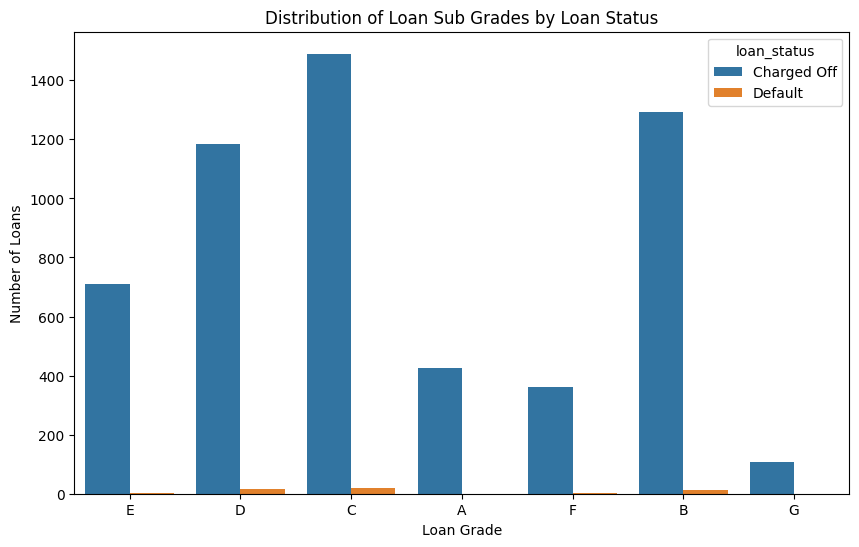

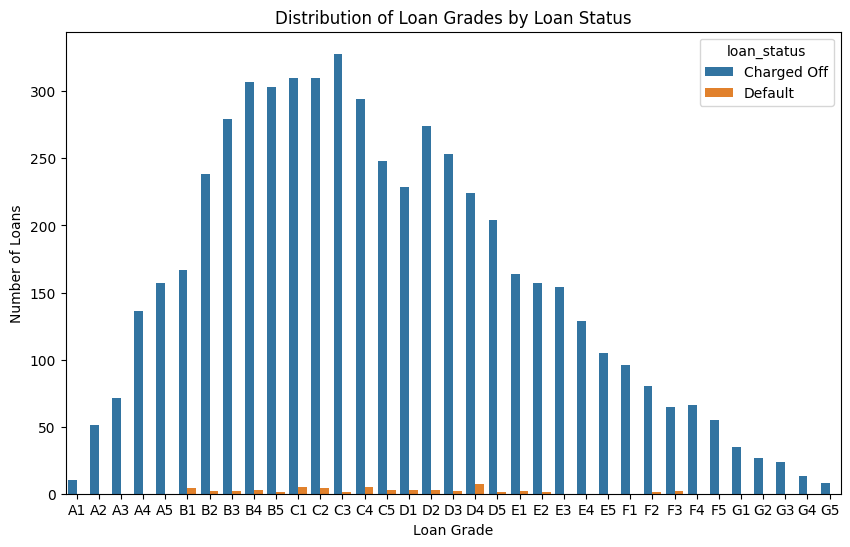

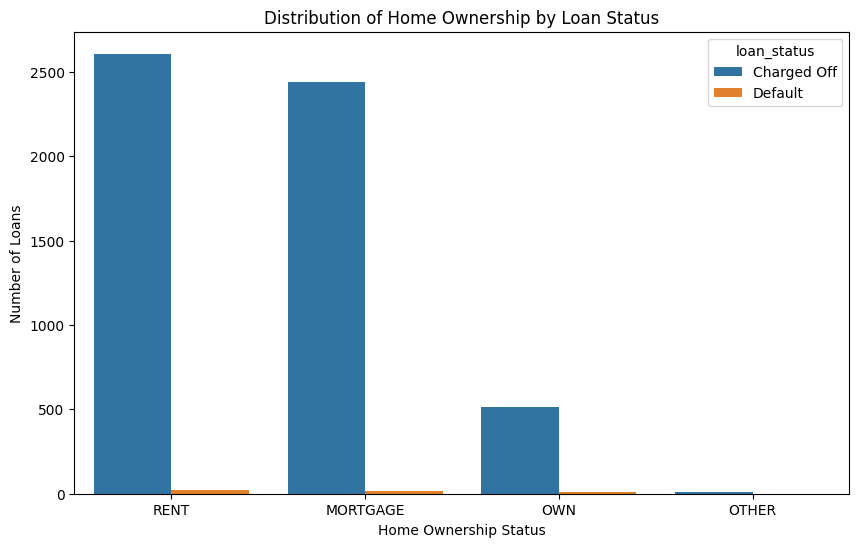

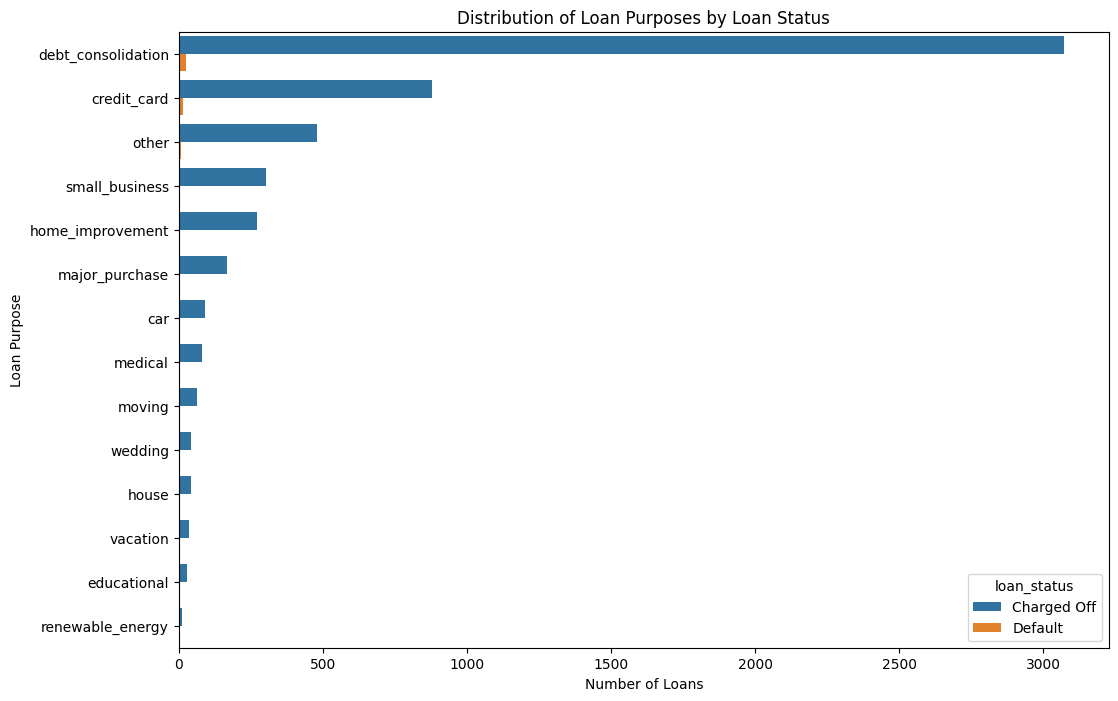

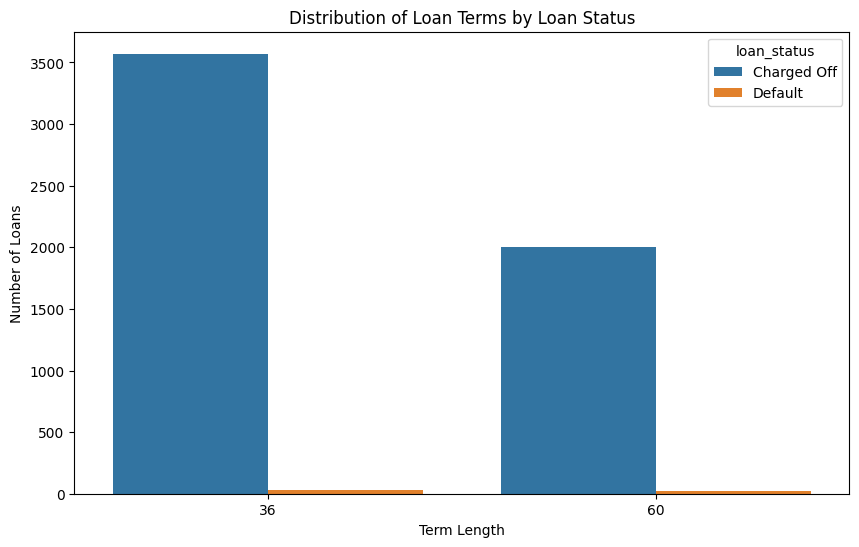

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
/var/folders/9x/39pmf5_s21v8y56mv544g7j40000gn/T/ipykernel_38807/2616546259.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/9x/39pmf5_s21v8y56mv544g7j40000gn/T/ipykernel_38807/2616546259.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/9x/39pmf5_s21v8y56mv544g7j40000gn/T/ipykernel_38807/2616546259.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/kamilleocadie-olsen/anaconda3/envs/analyst/lib/python3.12/site-packages/ipykernel/eventloops.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [6]:
def indicators_of_loss(dataframe):
    
    statuses = ["Charged Off", "Late (31-120 days)","Late (16-30 days)", "Default"]
    
    sub_dataframe = dataframe[dataframe["loan_status"].isin(statuses)]
    plotter.visualise_loan_grade(sub_dataframe)
    plotter.visualise_loan_subgrade(sub_dataframe)
    plotter.visualise_loan_home(sub_dataframe)
    plotter.visualise_loan_purpose(sub_dataframe)
    plotter.visualise_loan_term(sub_dataframe)
    

    
    
    show(dataframe)
    
indicators_of_loss(dataframe)